# Code for Bayesian Time Series Problem Set 1

The target density is mixture normal density as below
$$p(\theta) = \lambda \frac{1}{\sigma_1 \sqrt{2\pi}} e^{-\frac 1 2 (\frac{\theta-\mu_1}{\sigma_1})^2} +
(1- \lambda) \frac{1}{\sigma_2 \sqrt{2\pi}} e^{-\frac 1 2 (\frac{\theta-\mu_2}{\sigma_2})^2}$$

In [731]:
# import module
import numpy as np
import scipy
from scipy import stats
import math
import matplotlib.pyplot as plt
from pynverse import inversefunc

In [732]:
# initialize
lambda_ = 1/2
mu1 = -2
sigma1 = 1
mu2 = 2
sigma2 = 1

# momentum
true_expected = lambda_ * mu1 + (1-lambda_) * mu2
true_variance = lambda_ * (sigma1 ** 2 + mu1 ** 2) + (1-lambda_) * (sigma2 ** 2 + mu2 ** 2) - true_expected **2
true_expected, true_variance

(0.0, 5.0)

In [733]:
# target density
def p(theta,lambda_,mu1,sigma1,mu2,sigma2):
    item1 = lambda_ / (sigma1*math.sqrt(2*math.pi)) * np.exp(-0.5 * ((theta-mu1)/sigma1)**2)
    item2 = (1 - lambda_) / (sigma2*math.sqrt(2*math.pi)) * np.exp(-0.5 * ((theta-mu2)/sigma2)**2)
    return item1 + item2

In [734]:
def q(theta, method="normal", a=5):
    """
    Source density function
    given sample value theta, return the pdf
    """
    if method == "normal":
        return 1 / math.sqrt(2 * math.pi) * np.exp(-1/2 * (theta - 0.5) ** 2 )
    elif method == "uniform":
        if type(theta) is not np.ndarray:
            return 1/(2 * a)
        else:
            return 1/(2 * a) * np.ones(theta.shape)
    elif method == "tan":
        return 1/ (1 + theta**2)
    elif method == "mix normal":
        return p(theta,lambda_,mu1,sigma1,mu2,sigma2)

In [735]:
def cdf_transform(q, n, method):
    """
    function to sample a theta from a pdf function q
    n: how many samples to be returned
    """
    #  get a probability value
    prob = np.random.uniform(0,1, n) 
    
    # compute by theoretical inverse cdf
    if method == "normal":
        return np.random.normal(0.5, 1, n)
    
    elif method == "uniform":
        return np.random.uniform(-10, 10, n)
    
    elif method == "tan":
        return np.tan(prob-math.pi/2)
    
    elif method == "mix normal":
        cdf = lambda x: 1/2 + 1/2 * (lambda_ * scipy.special.erf((x-mu1)/(sigma1 * np.sqrt(2))) \
                                              + (1 - lambda_) * scipy.special.erf((x-mu2)/(sigma2 * np.sqrt(2))) )
        return inversefunc(cdf, y_values=prob)
    

In [738]:
# iterative algo
def accept_rej_algo(p,q,lambda_,mu1,sigma1,mu2,sigma2,true_expected,true_variance,a=5, method="uniform", max_iter=10000):
    """
    run : how many runs you need, that is, how many simulated theta you need
    max_iter : maximum iteration time
    """
    
    def accept_alpha(theta):
        # define acceptance rate for accept-reject algo
        return p(theta,lambda_,mu1,sigma1,mu2,sigma2)/q(theta,method)
    
    def simulate(c,n=10): 
        # simulate n points
        # sample theta from source distribution q using inverse cdf transformation
        theta = cdf_transform(q, n, method)
        #  # theta sampled from uniform q
        criteria = accept_alpha(theta) / c
        return criteria, theta
    print("Begin acceptance-reject algorithm with %s distribution"%method)
    # compute c
    thetas = np.linspace(-a,a,max_iter)
    c = np.max(p(thetas,lambda_,mu1,sigma1,mu2,sigma2)/q(thetas,a=a, method=method))
    
    
    
    accepted_theta = [] # save the accepted theta
    found = 0 # find the minimal iter to get mean and var within 0.01
    maxwhile = 0
    while found == 0 and maxwhile <= 10:
        # begin to compute iterations
        U = np.random.uniform(0, 1, max_iter) # the uniform U to be compared with alpha
        criteria, theta = simulate(c,max_iter)

        accepid = (U <= criteria)
        accepted_theta_total = theta[accepid]
        for i in range(100, len(accepted_theta_total)):
            accepted_theta = accepted_theta_total[:i+1]
            sim_mean = np.mean(accepted_theta)
            sim_var = np.var(accepted_theta)
            if abs(sim_mean-true_expected) < 0.01 and abs(sim_var-true_variance) < 0.01:
                found = 1
                print("It requires %i draws to find simulated mean and variance less than 0.01 from true values"%(i+1))
                break
        maxwhile += 1
        if found == 0 and maxwhile == 11:
            print("The maximal draws %i is not enough to find the required mean and var in this iteration"%max_iter)
        

    print("simulated mean is %.4f and simulated variance is %.4f"%(np.mean(accepted_theta),np.var(accepted_theta)))
    return accepted_theta, c


Begin acceptance-reject algorithm with uniform distribution
It requires 1883 draws to find simulated mean and variance less than 0.01 from true values
simulated mean is -0.0100 and simulated variance is 4.9942
c is determined as 1.9954
Finished Simulation with source function of uniform 

Begin acceptance-reject algorithm with normal distribution
The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is nan and simulated variance is nan
c is determined as 1688.9342


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users

Finished Simulation with source function of normal 

Begin acceptance-reject algorithm with mix normal distribution


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3ef399>:10: RuntimeWarning: invalid value encountered in true_divide
  return p(theta,lambda_,mu1,sigma1,mu2,sigma2)/q(theta,method)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3ef399>:10: RuntimeWarning: invalid value encountered in true_divide
  return p(theta,lambda_,mu1,sigma1,mu2,sigma2)/q(theta,method)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3e

The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is -0.0512 and simulated variance is 15.7826
c is determined as 1.0000
Finished Simulation with source function of mix normal 

Begin acceptance-reject algorithm with uniform distribution
It requires 16606 draws to find simulated mean and variance less than 0.01 from true values
simulated mean is -0.0099 and simulated variance is 5.0020
c is determined as 1.9954
Finished Simulation with source function of uniform 

Begin acceptance-reject algorithm with normal distribution
The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is nan and simulated variance is nan
c is determined as 1688.9342
Finished Simulation with source function of normal 

Begin acceptance-reject algorithm with mix normal distribution


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users

The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is -0.0361 and simulated variance is 15.5207
c is determined as 1.0000
Finished Simulation with source function of mix normal 

Begin acceptance-reject algorithm with uniform distribution
It requires 3543 draws to find simulated mean and variance less than 0.01 from true values
simulated mean is -0.0073 and simulated variance is 5.0089
c is determined as 1.9954
Finished Simulation with source function of uniform 

Begin acceptance-reject algorithm with normal distribution
The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is nan and simulated variance is nan
c is determined as 1688.9342


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users

Finished Simulation with source function of normal 

Begin acceptance-reject algorithm with mix normal distribution


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3ef399>:10: RuntimeWarning: invalid value encountered in true_divide
  return p(theta,lambda_,mu1,sigma1,mu2,sigma2)/q(theta,method)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3ef399>:10: RuntimeWarning: invalid value encountered in true_divide
  return p(theta,lambda_,mu1,sigma1,mu2,sigma2)/q(theta,method)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3e

The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is -0.0585 and simulated variance is 16.5123
c is determined as 1.0000
Finished Simulation with source function of mix normal 

Begin acceptance-reject algorithm with uniform distribution
It requires 7153 draws to find simulated mean and variance less than 0.01 from true values
simulated mean is -0.0098 and simulated variance is 5.0094
c is determined as 1.9954
Finished Simulation with source function of uniform 

Begin acceptance-reject algorithm with normal distribution
The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is nan and simulated variance is nan
c is determined as 1688.9342
Finished Simulation with source function of normal 

Begin acceptance-reject algorithm with mix normal distribution


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users

The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is -0.0329 and simulated variance is 15.3543
c is determined as 1.0000
Finished Simulation with source function of mix normal 

Begin acceptance-reject algorithm with uniform distribution
It requires 1196 draws to find simulated mean and variance less than 0.01 from true values
simulated mean is 0.0090 and simulated variance is 4.9928
c is determined as 1.9954
Finished Simulation with source function of uniform 

Begin acceptance-reject algorithm with normal distribution
The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is nan and simulated variance is nan
c is determined as 1688.9342


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users

Finished Simulation with source function of normal 

Begin acceptance-reject algorithm with mix normal distribution


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3ef399>:10: RuntimeWarning: invalid value encountered in true_divide
  return p(theta,lambda_,mu1,sigma1,mu2,sigma2)/q(theta,method)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3ef399>:10: RuntimeWarning: invalid value encountered in true_divide
  return p(theta,lambda_,mu1,sigma1,mu2,sigma2)/q(theta,method)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3e

The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is -0.0440 and simulated variance is 15.8825
c is determined as 1.0000
Finished Simulation with source function of mix normal 

Begin acceptance-reject algorithm with uniform distribution
It requires 2101 draws to find simulated mean and variance less than 0.01 from true values
simulated mean is -0.0012 and simulated variance is 4.9925
c is determined as 1.9954
Finished Simulation with source function of uniform 

Begin acceptance-reject algorithm with normal distribution
The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is nan and simulated variance is nan
c is determined as 1688.9342


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users

Finished Simulation with source function of normal 

Begin acceptance-reject algorithm with mix normal distribution


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3ef399>:10: RuntimeWarning: invalid value encountered in true_divide
  return p(theta,lambda_,mu1,sigma1,mu2,sigma2)/q(theta,method)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3ef399>:10: RuntimeWarning: invalid value encountered in true_divide
  return p(theta,lambda_,mu1,sigma1,mu2,sigma2)/q(theta,method)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3e

The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is -0.0518 and simulated variance is 16.3144
c is determined as 1.0000
Finished Simulation with source function of mix normal 

Begin acceptance-reject algorithm with uniform distribution
It requires 2963 draws to find simulated mean and variance less than 0.01 from true values
simulated mean is -0.0099 and simulated variance is 4.9998
c is determined as 1.9954
Finished Simulation with source function of uniform 

Begin acceptance-reject algorithm with normal distribution
The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is nan and simulated variance is nan
c is determined as 1688.9342
Finished Simulation with source function of normal 

Begin acceptance-reject algorithm with mix normal distribution


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users

The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is -0.0344 and simulated variance is 15.8355
c is determined as 1.0000


<ipython-input-744-5af1c6dfed60>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3,figsize=(15,3))


Finished Simulation with source function of mix normal 

Begin acceptance-reject algorithm with uniform distribution
It requires 3652 draws to find simulated mean and variance less than 0.01 from true values
simulated mean is -0.0070 and simulated variance is 4.9919
c is determined as 1.9954


<ipython-input-744-5af1c6dfed60>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3,figsize=(15,3))


Finished Simulation with source function of uniform 

Begin acceptance-reject algorithm with normal distribution
The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is nan and simulated variance is nan
c is determined as 1688.9342


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipyth

Finished Simulation with source function of normal 

Begin acceptance-reject algorithm with mix normal distribution


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3ef399>:10: RuntimeWarning: invalid value encountered in true_divide
  return p(theta,lambda_,mu1,sigma1,mu2,sigma2)/q(theta,method)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3ef399>:10: RuntimeWarning: invalid value encountered in true_divide
  return p(theta,lambda_,mu1,sigma1,mu2,sigma2)/q(theta,method)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3e

The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is -0.0396 and simulated variance is 16.1455
c is determined as 1.0000


<ipython-input-744-5af1c6dfed60>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3,figsize=(15,3))


Finished Simulation with source function of mix normal 

Begin acceptance-reject algorithm with uniform distribution
It requires 274 draws to find simulated mean and variance less than 0.01 from true values
simulated mean is 0.0027 and simulated variance is 4.9942
c is determined as 1.9954


<ipython-input-744-5af1c6dfed60>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3,figsize=(15,3))


Finished Simulation with source function of uniform 

Begin acceptance-reject algorithm with normal distribution
The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is nan and simulated variance is nan
c is determined as 1688.9342


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipyth

Finished Simulation with source function of normal 

Begin acceptance-reject algorithm with mix normal distribution


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3ef399>:10: RuntimeWarning: invalid value encountered in true_divide
  return p(theta,lambda_,mu1,sigma1,mu2,sigma2)/q(theta,method)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3ef399>:10: RuntimeWarning: invalid value encountered in true_divide
  return p(theta,lambda_,mu1,sigma1,mu2,sigma2)/q(theta,method)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3e

The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is -0.0496 and simulated variance is 16.2841
c is determined as 1.0000


<ipython-input-744-5af1c6dfed60>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3,figsize=(15,3))


Finished Simulation with source function of mix normal 

Begin acceptance-reject algorithm with uniform distribution
It requires 541 draws to find simulated mean and variance less than 0.01 from true values
simulated mean is -0.0011 and simulated variance is 4.9977
c is determined as 1.9954


<ipython-input-744-5af1c6dfed60>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3,figsize=(15,3))


Finished Simulation with source function of uniform 

Begin acceptance-reject algorithm with normal distribution
The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is nan and simulated variance is nan
c is determined as 1688.9342


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipyth

Finished Simulation with source function of normal 

Begin acceptance-reject algorithm with mix normal distribution


/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3ef399>:10: RuntimeWarning: invalid value encountered in true_divide
  return p(theta,lambda_,mu1,sigma1,mu2,sigma2)/q(theta,method)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3ef399>:10: RuntimeWarning: invalid value encountered in true_divide
  return p(theta,lambda_,mu1,sigma1,mu2,sigma2)/q(theta,method)
/Users/zijianleowang/opt/anaconda3/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
<ipython-input-738-e2721e3e

The maximal draws 100000 is not enough to find the required mean and var in this iteration
simulated mean is -0.0374 and simulated variance is 15.8499
c is determined as 1.0000


<ipython-input-744-5af1c6dfed60>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3,figsize=(15,3))


Finished Simulation with source function of mix normal 

on average of 10 simulations, it requires 0.0000 draws for normal distribution,and 3991.2000 draws for uniform distribution, and 92190.1000 draws for source = target distribution


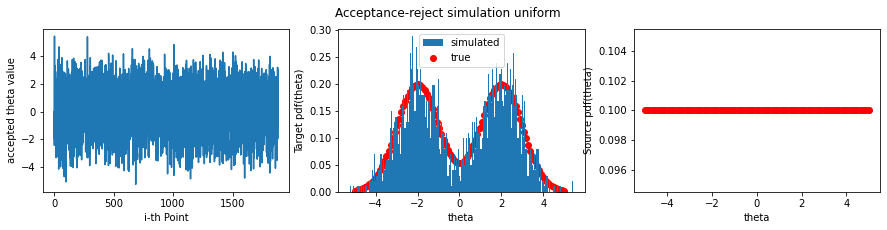

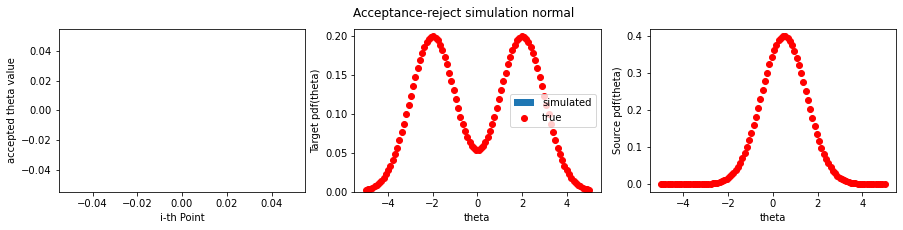

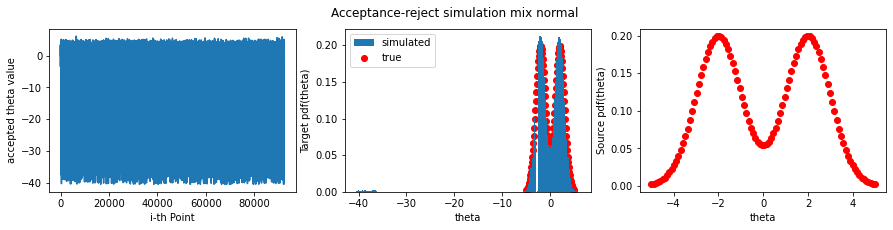

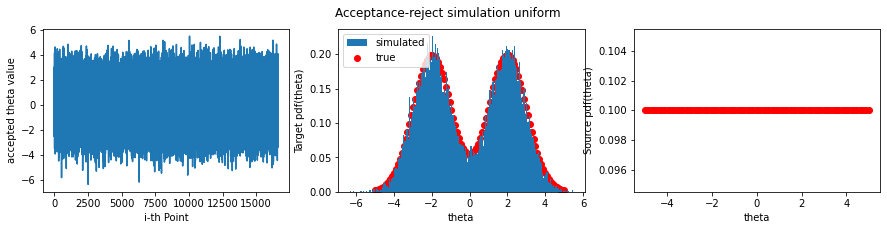

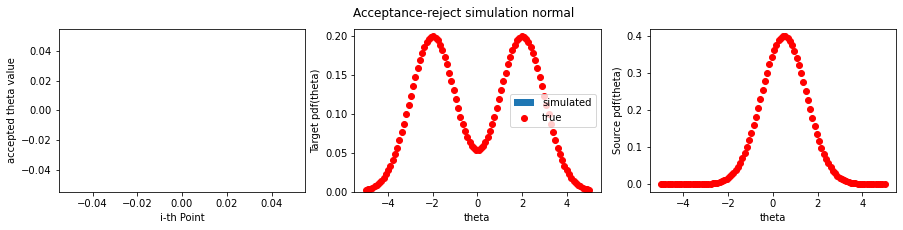

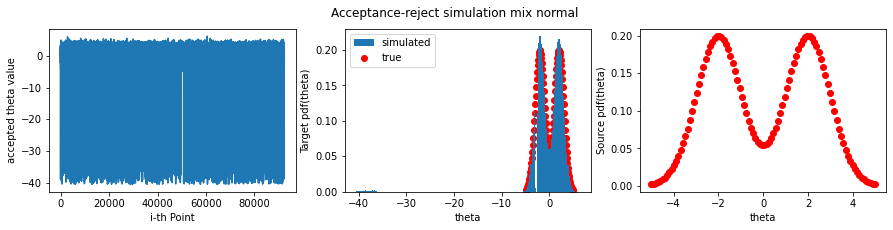

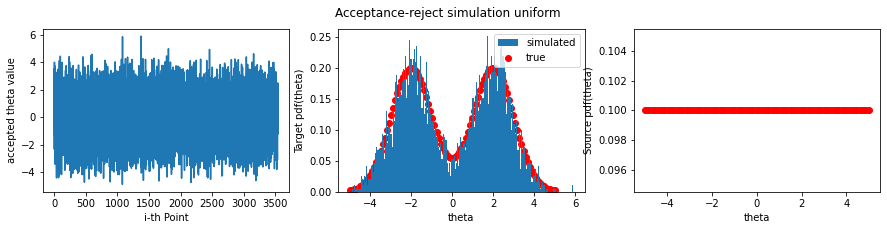

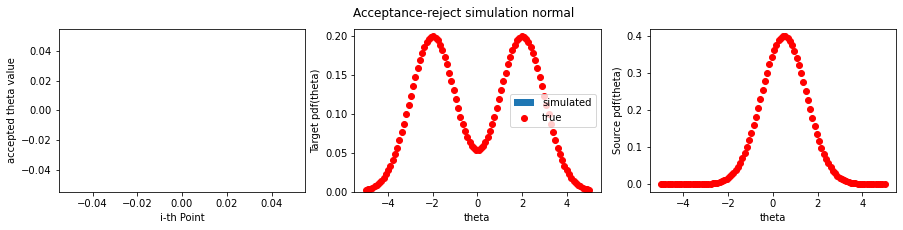

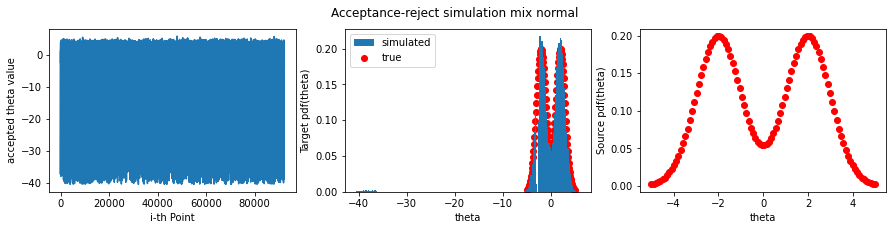

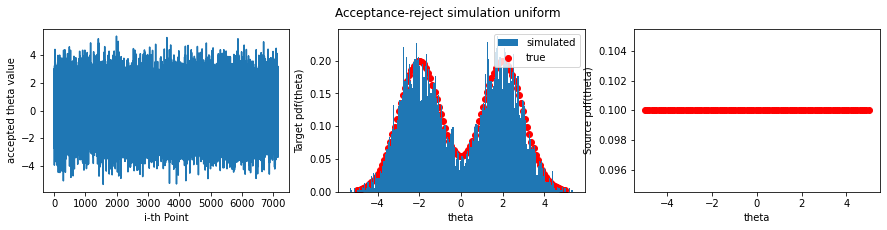

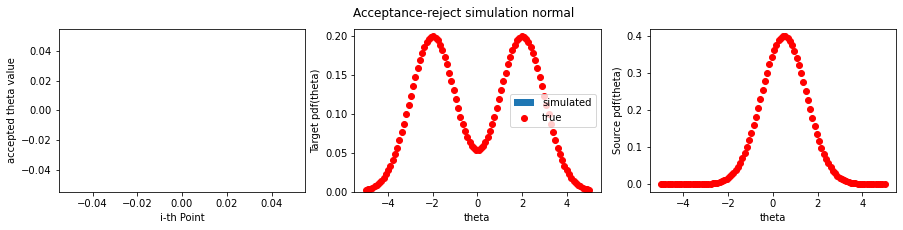

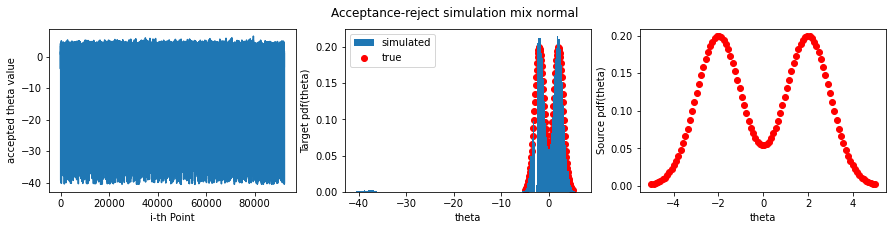

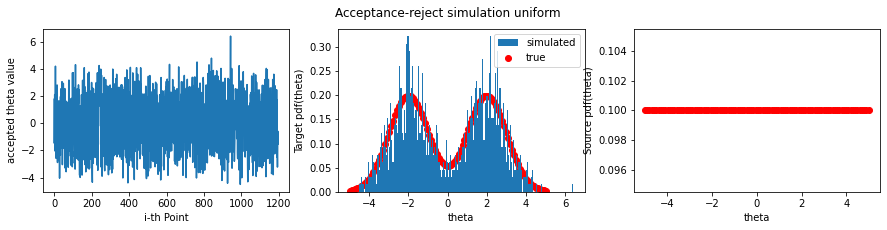

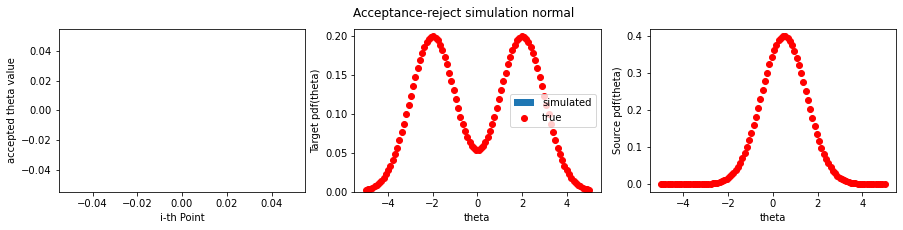

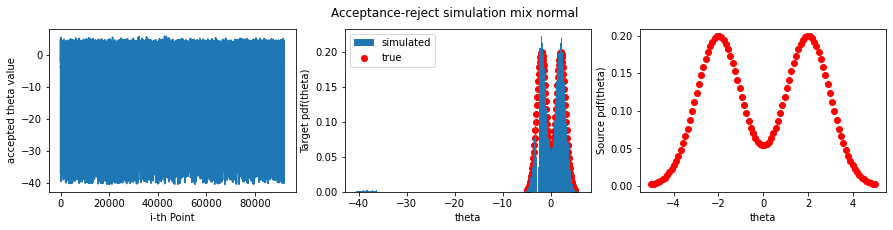

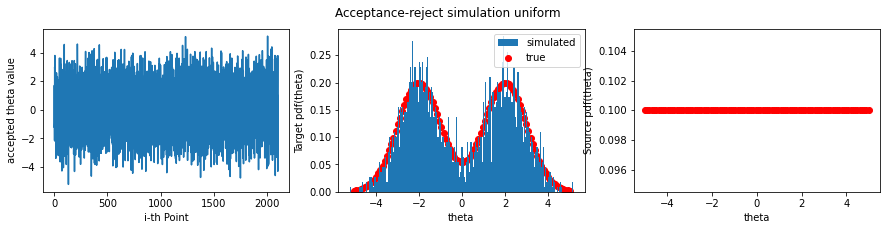

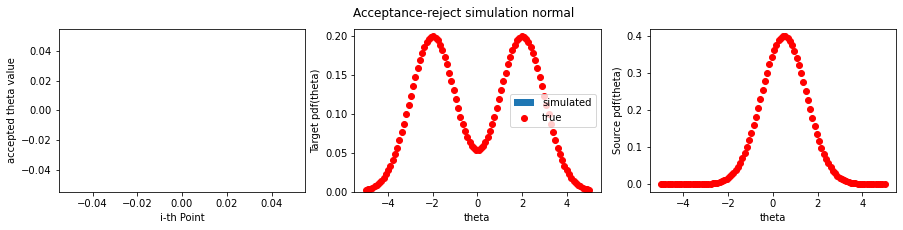

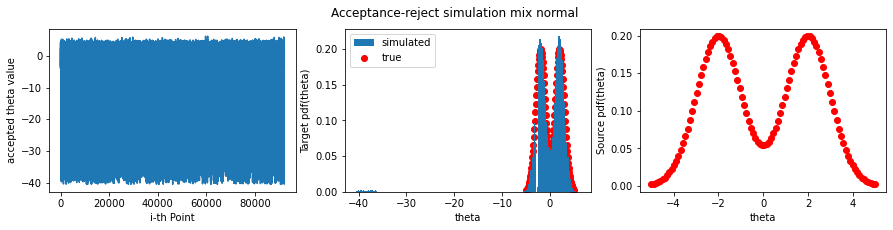

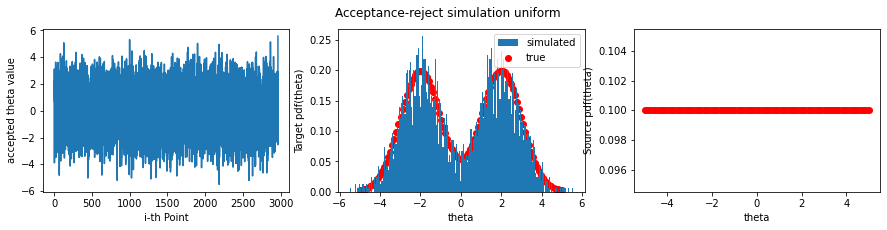

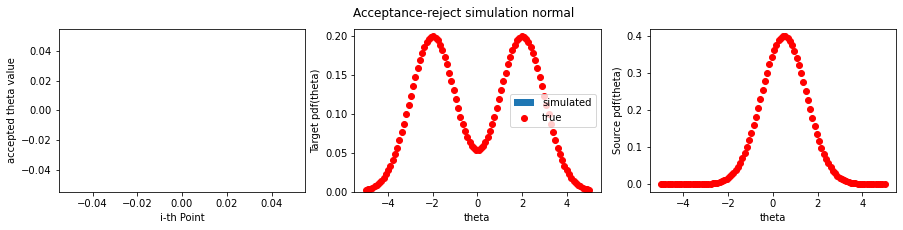

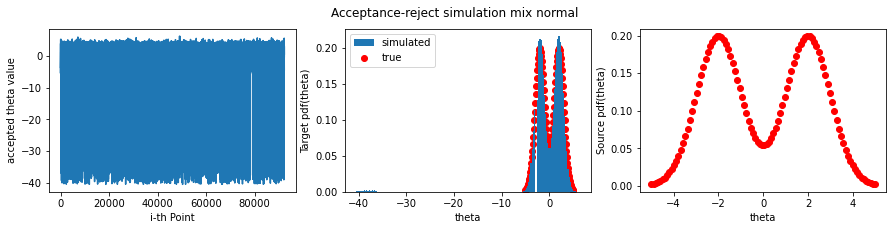

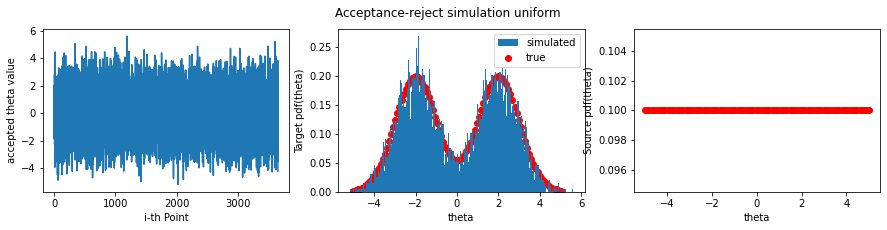

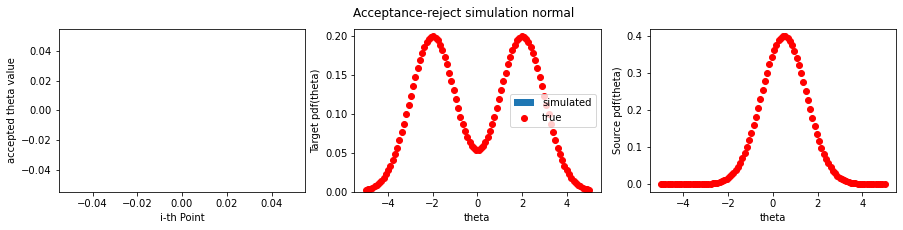

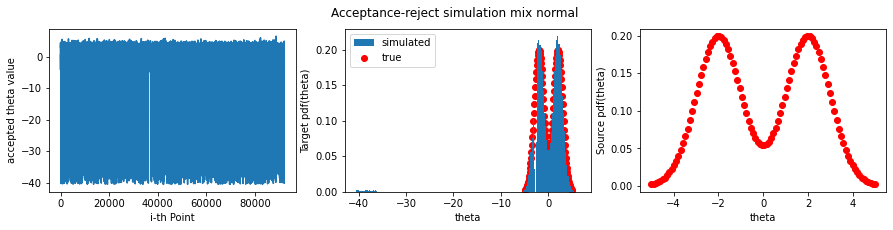

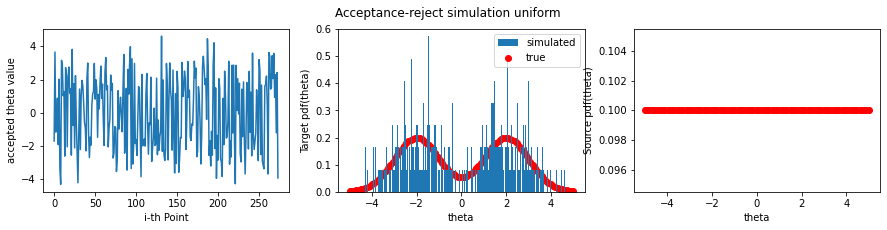

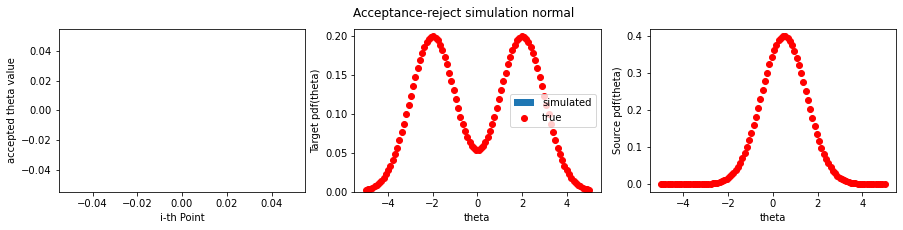

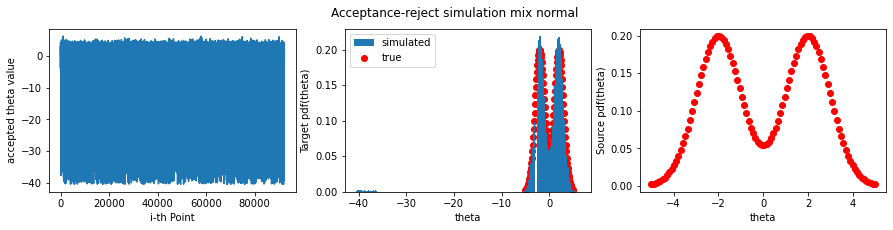

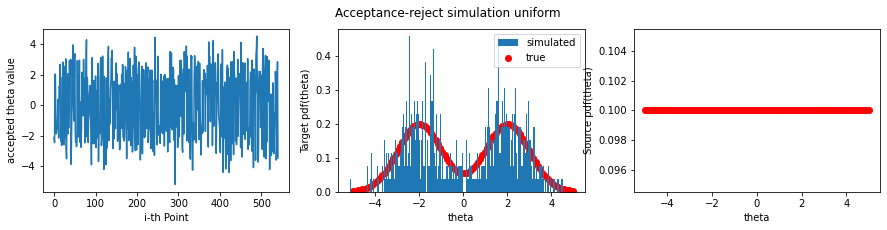

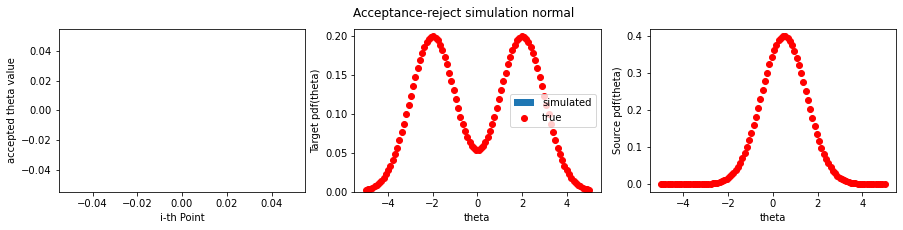

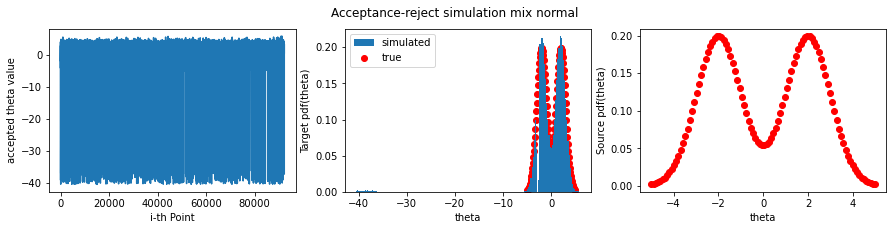

In [744]:
# accept-reject method
def ar_main(max_iter,method,a):
    samples, c = accept_rej_algo(p,q,lambda_,mu1,sigma1,mu2,sigma2,true_expected,true_variance,a=a,
                                              method=method,max_iter=max_iter)
    draws = len(samples)
    print("c is determined as %.4f"%c)
    fig, ax = plt.subplots(1,3,figsize=(15,3))
    fig.suptitle("Acceptance-reject simulation %s"%method)
    ax[0].plot(samples)
    ax[0].set_ylabel("accepted theta value")
    ax[0].set_xlabel("i-th Point")
    # simulated
    temp = ax[1].hist(samples, density=True, bins=200,label='simulated')
    # viz the target function
    x = np.linspace(-5,5,100)
    ax[1].scatter(x,p(x,lambda_,mu1,sigma1,mu2,sigma2),color='r',label='true')
    ax[1].set_xlabel("theta")
    ax[1].set_ylabel("Target pdf(theta)")
    ax[1].legend()
    # viz the source function
    ax[2].scatter(x,q(x,method,a),color='r')
    ax[2].set_xlabel("theta")
    ax[2].set_ylabel("Source pdf(theta)")

    print("Finished Simulation with source function of %s \n"%method)
    return draws

max_iter = 200000

run_uni = []
run_normal = []
run_mix = []
for i in range(10):
    iter1 = ar_main(max_iter,method="uniform",a=5)
    iter2 = ar_main(max_iter,method="normal",a=4)
    iter3 = ar_main(max_iter,method="mix normal",a=3)
    run_uni.append(iter1)
    run_normal.append(iter2)
    run_mix.append(iter3)
print("on average of 10 simulations, it requires %.4f draws for normal distribution,\
and %.4f draws for uniform distribution, and %.4f draws for source = target distribution"%(np.mean(run_normal),\
                                                                                           np.mean(run_uni), np.mean(run_mix)) )

In [740]:
def importance_algo(p,q,lambda_,mu1,sigma1,mu2,sigma2,method="uniform",run=1000):
    """
    importance sampling to estimate expected value and variance
    run : how many points you need to estimate the expectation and variance
    """
    def mean_value(theta):
        return theta
    def variance_value(theta,mu):
        return (theta-mu)**2
    if method == "uniform":
        theta = np.random.uniform(-5, 5, run)
    elif method == "normal":
        theta = np.random.normal(0.5, 1, run)
    q_theta = q(theta,method)
    p_theta = p(theta,lambda_,mu1,sigma1,mu2,sigma2)
    weights = p_theta/q_theta
    expected = weights @ mean_value(theta) / sum(weights)
    variance = weights @ variance_value(theta,expected) / sum(weights) 
    return expected, variance

In [741]:
def importance_main(method,maxrun=10000):
    print("Begin the importance sampling with %s"%method)
    found = 0
    for k in range(10,maxrun):
        expected, variance = importance_algo(p,q,lambda_,mu1,sigma1,mu2,sigma2,method=method,run=k)
        diff_exp = np.abs(expected-true_expected)
        diff_var = np.abs(variance-true_variance)
        if diff_exp <= 0.01 and diff_var <= 0.01:
            print("%i-th run needed to find"%k)
            print("Simulated expected value is %.4f"%expected, "True expected value is %.4f"%true_expected,\
                  "absolute difference is %.4f"%(diff_exp) )
            print("Simulated variance value is %.4f"%variance, "True variance value is %.4f"%true_variance,\
                  "absolute difference is %.4f"%(diff_var) )
            print("Finished\n")
            found = 1
            break
    if found == 0:
        print("%i is not enough to find the expected answers"%maxrun)
    return k

run_uni = []
run_normal = []
for i in range(10):
    k1 = importance_main("uniform")
    k2 = importance_main("normal")
    run_uni.append(k1)
    run_normal.append(k2)
print("on average of 10 simulations, it requires %.4f draws for normal distribution, and %.4f draws for uniform distribution"%(np.mean(run_normal),np.mean(run_uni)))


Begin the importance sampling with uniform
208-th run needed to find
Simulated expected value is -0.0004 True expected value is 0.0000 absolute difference is 0.0004
Simulated variance value is 4.9979 True variance value is 5.0000 absolute difference is 0.0021
Finished

Begin the importance sampling with normal
777-th run needed to find
Simulated expected value is -0.0080 True expected value is 0.0000 absolute difference is 0.0080
Simulated variance value is 5.0059 True variance value is 5.0000 absolute difference is 0.0059
Finished

Begin the importance sampling with uniform
448-th run needed to find
Simulated expected value is -0.0074 True expected value is 0.0000 absolute difference is 0.0074
Simulated variance value is 5.0065 True variance value is 5.0000 absolute difference is 0.0065
Finished

Begin the importance sampling with normal
6701-th run needed to find
Simulated expected value is -0.0076 True expected value is 0.0000 absolute difference is 0.0076
Simulated variance value i

In [742]:
# Metropolis Hastings Algo - Most general posterior simulator
def metropolis_hastings(p, lambda_,mu1,sigma1,mu2,sigma2, theta0, n_samples=10000, method="independence"):
    """
    Metropolis-Hastings algorithm for sampling from a target distribution p using a proposal distribution q.
    
    Parameters:
    p (function): the target density function from which we want to sample
    q (function): the proposal density function
    theta0 (float or array-like): the initial state of the chain
    n_samples (int): the number of samples to draw
    
    Returns:
    samples (ndarray): an array of shape (n_samples,) containing the samples drawn from p
    """
    
    # the proposal density q is a normal with mean of 0.5 and sigma of 1
    def q(theta_star, theta, sigma):
        # calculate the pdf given theta
        if method == "independence":
            # the independence chain Metropolis-Hastings Algo
            return 1 / math.sqrt(2 * math.pi) * np.exp(-1/2 * (theta_star - 0.5) ** 2 )
        elif method == "random walk":
            # given /Sigma of 1 and center of theta
            return 1 / math.sqrt(2 * math.pi) * np.exp(-1/2 * (theta_star - theta) ** 2 )
        elif method == "adaptive rw":
            return 1 / math.sqrt(2 * math.pi) / sigma * np.exp(-1/2 * ((theta_star - theta)/sigma) ** 2 )
            
    def simulate(samples):
        samples = np.array(samples)
        theta = samples[-1]
        s = len(samples)
        if method == "independence":
            # independence chain metropolis-hastings algorithm
            return np.random.normal(0.5, 1), 1
        elif method == "random walk":
            # random walk chain metropolis hastings algorithm
            z = np.random.normal(0,1) # /Sigma = 1 here in the case with center of 0
            return theta + z, 1
        elif method == "adaptive rw":
            # adaptive random walk chain metropolis hastings algorithm
            c = 1.0
            if s <= 10:
                Sigma = 1.0
            else:
                # Sigma = c * np.var(samples, ddof=1)
                Sigma = c * np.sum(samples ** 2) / s
            z = np.random.normal(0, np.sqrt(Sigma))
            return theta + z, np.sqrt(Sigma)
    
    
    theta = theta0 # init
    samples = [theta]
    acceptance = [0]# acceptance rate refers to the ratio of the number of proposals that are accepted to the total number of proposals generated during the sampling process.
    s = 1 # s-th state
    for i in range(n_samples):
        theta_star, sigma = simulate(samples) # generate a candidate sample from the proposal distribution
        alpha = min(1, \
                    p(theta_star,lambda_,mu1,sigma1,mu2,sigma2) * q(theta, theta_star, sigma) / (p(theta,lambda_,mu1,sigma1,mu2,sigma2) * q(theta_star, theta, sigma)) ) # calculate the acceptance probability
        u = np.random.uniform()
        
        if u <= alpha:
            theta = theta_star # accept the candidate sample
            acceptance.append(1)
        # else the theta remains the same
        samples.append(theta)
        acceptance.append(0)
        s += 1
    return samples, acceptance

MH for method of independence
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Simulated expected value is 0.0031 True expected value is 0.0000 absolute difference is 0.0031
Simulated variance value is 5.0064 True variance value is 5.0000 absolute difference is 0.0064
stop at 799-th draws
Finished Simulation

Begin the 1-th run
Begin the 1-th run
Begin the 1-th run
Begin the 1-th run
Begin the 1-th run
Begin the 1-th run
Simulated expected value is 0.0089 True expected value is 0.0000 absolute difference is 0.0089
Simulated variance value is 5.0093 True variance value is 5.0000 absolute difference is 0.0093
stop at 1286-th 

<ipython-input-743-26e5d7b172ad>:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2,figsize=(10,3))


Begin the 10-th run
Begin the 10-th run
Begin the 10-th run
Begin the 10-th run
Begin the 10-th run
Begin the 10-th run
Begin the 10-th run
Simulated expected value is 0.0087 True expected value is 0.0000 absolute difference is 0.0087
Simulated variance value is 5.0069 True variance value is 5.0000 absolute difference is 0.0069
stop at 1572-th draws
Finished Simulation

for random walk, the average draws are 2321.4545, the average mean is 0.0006, average variance is 5.0006,    the average acceptance rate is 0.4313 

MH for method of adaptive rw
Begin the 0-th run
Begin the 0-th run
Begin the 0-th run
Simulated expected value is -0.0075 True expected value is 0.0000 absolute difference is 0.0075
Simulated variance value is 5.0093 True variance value is 5.0000 absolute difference is 0.0093
stop at 598-th draws
Finished Simulation

Begin the 1-th run
Begin the 1-th run
Simulated expected value is 0.0073 True expected value is 0.0000 absolute difference is 0.0073
Simulated variance value i

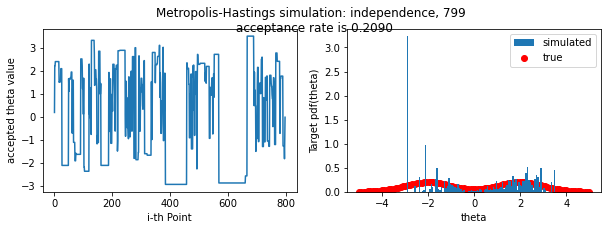

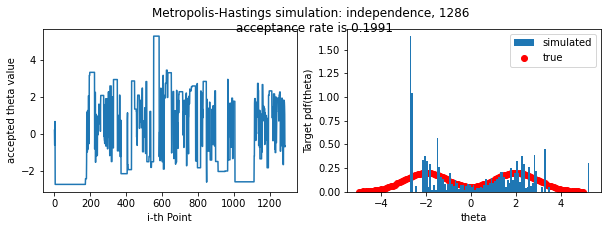

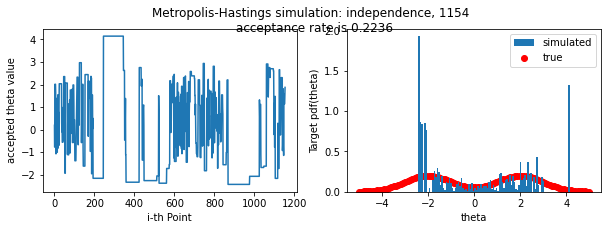

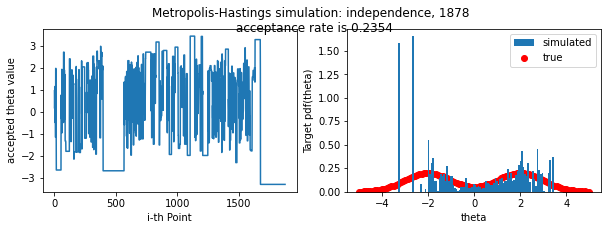

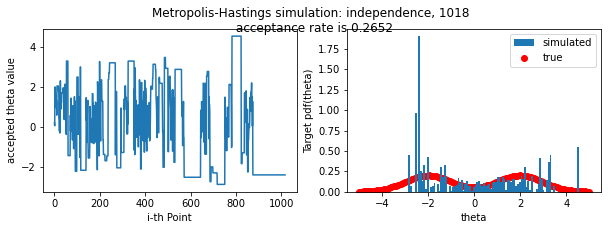

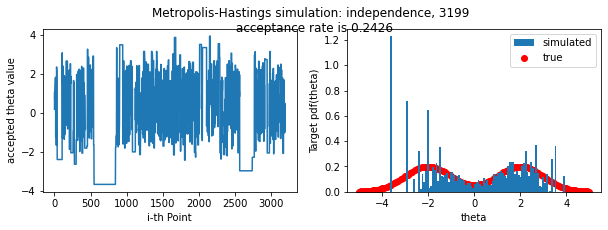

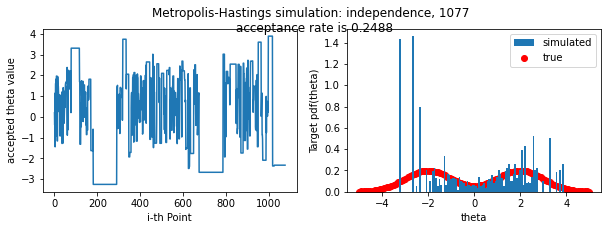

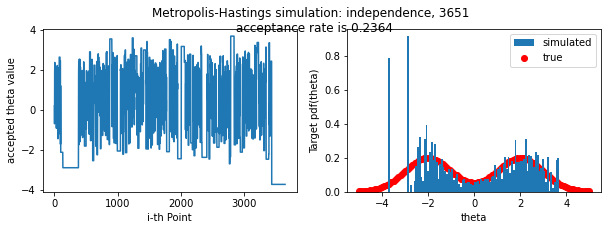

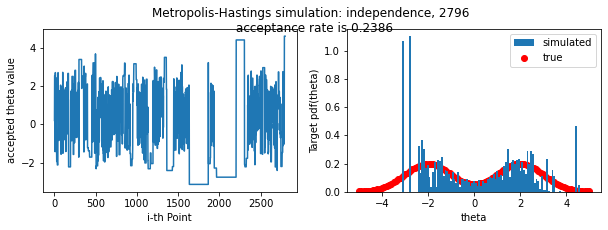

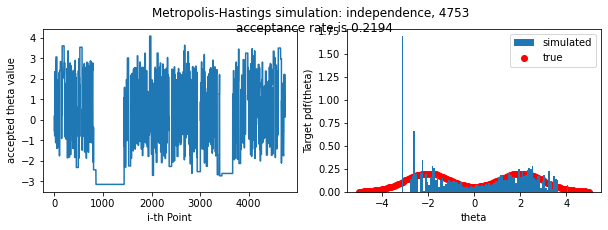

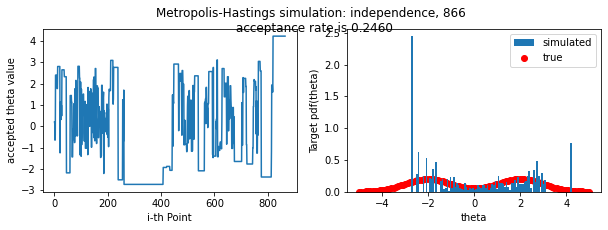

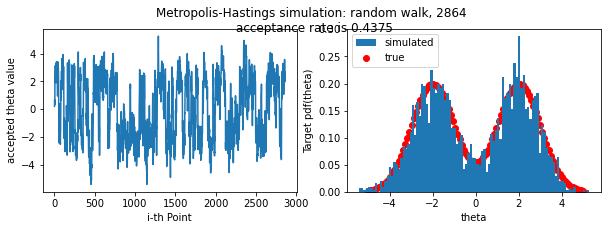

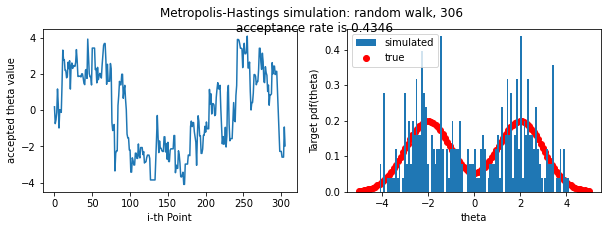

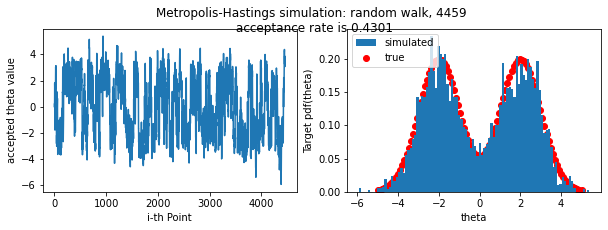

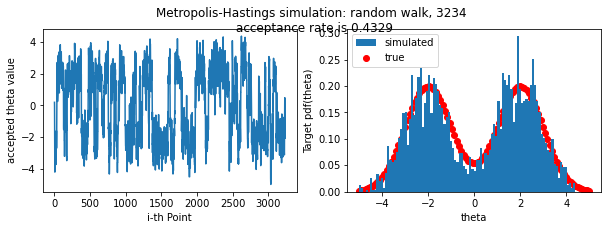

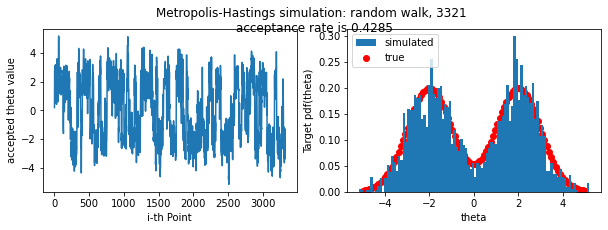

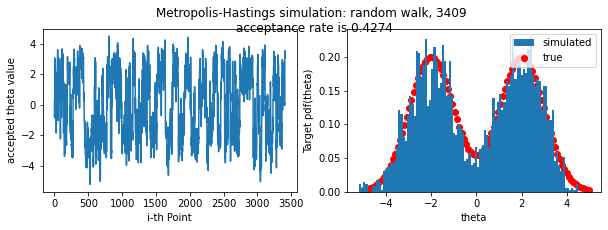

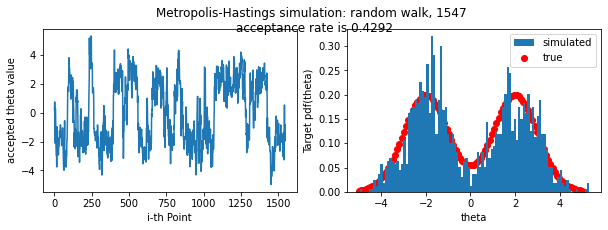

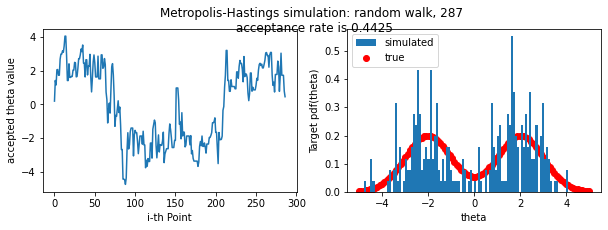

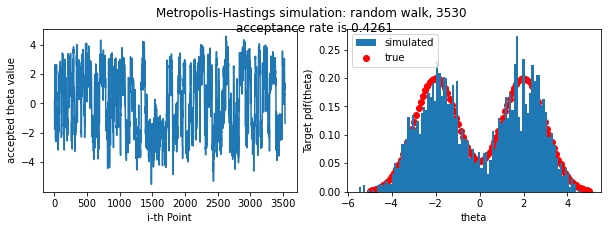

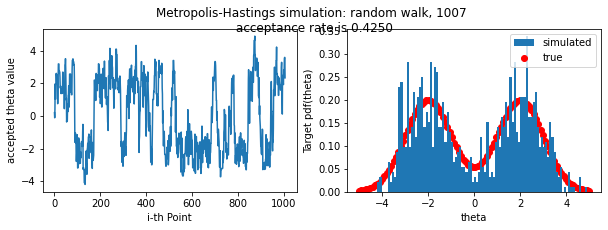

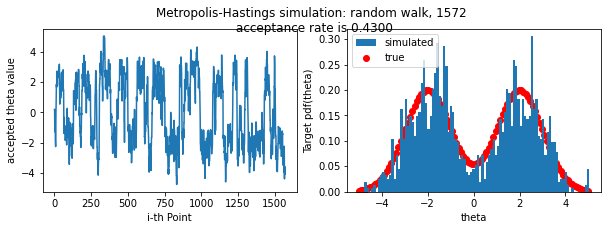

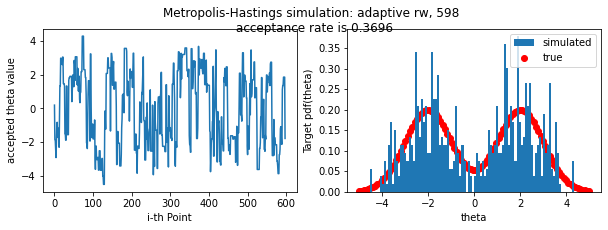

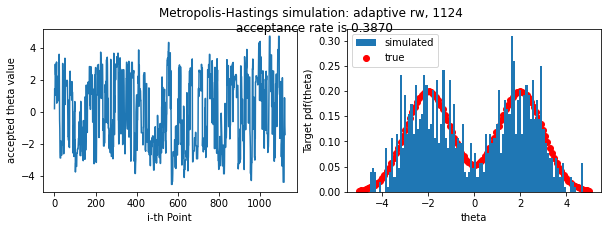

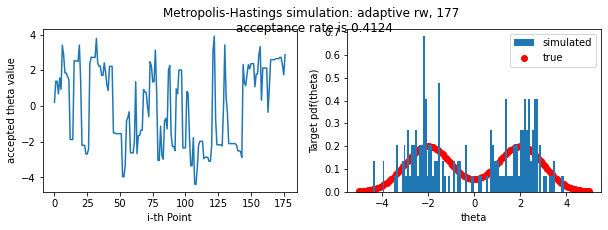

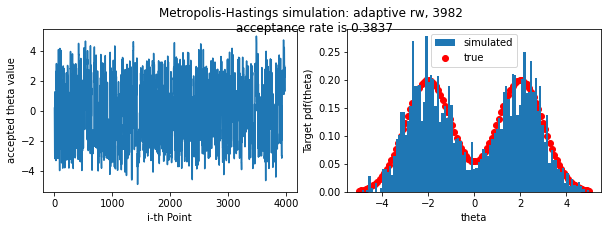

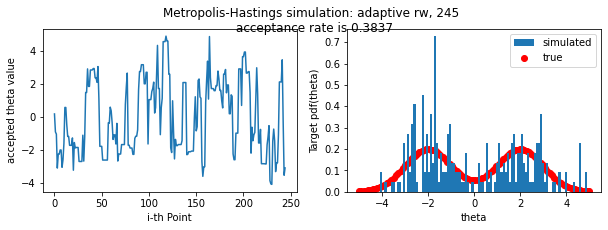

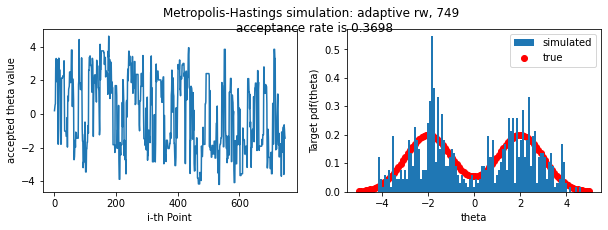

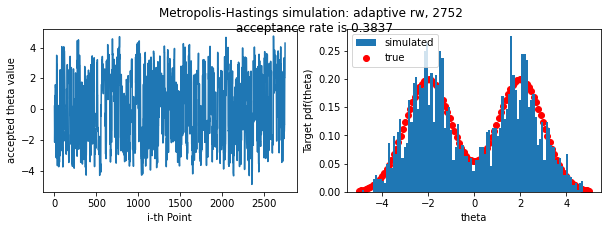

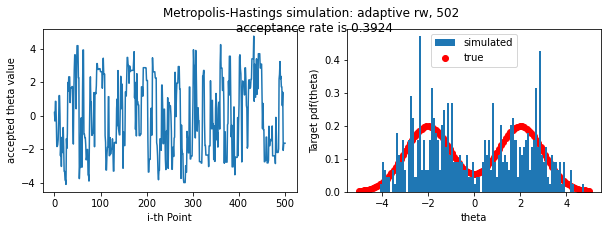

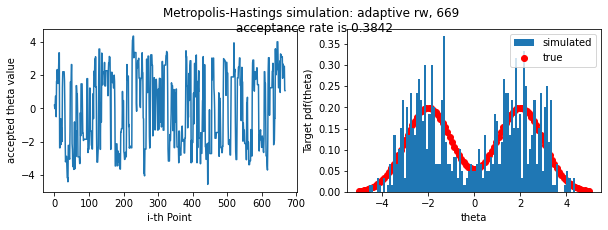

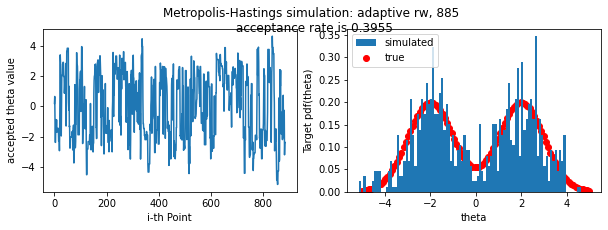

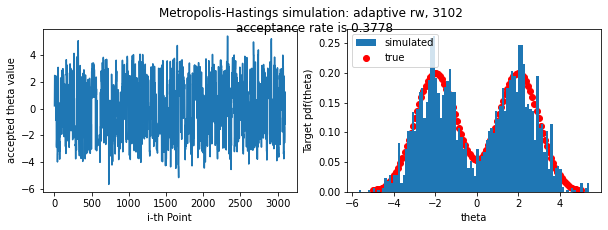

In [743]:
# MH

for method in ["independence","random walk","adaptive rw"]:
    print("MH for method of %s"%method)
    draws = []
    exps = []
    var = []
    acc = []
    run = 0
    while run <= 10: # on average 10 runs 
        print("Begin the %i-th run"%run)
        found = 0
        total_samples, acceptance = metropolis_hastings(p, lambda_,mu1,sigma1,mu2,sigma2,method=method,\
                                          theta0=0.2, n_samples=10000)
        for n_samples in range(100, 5000): # how many draws to generate it?
            samples = total_samples[:n_samples]
            # find the one within 0.01
            expected = np.mean(samples)
            variance = np.var(samples)
            diff_exp = np.abs(expected - true_expected)
            diff_var = np.abs(variance - true_variance)
            if diff_exp <= 0.01 and diff_var <= 0.01: # >1000 to constrain the acceptance ratio between 0.2-0.3
                found = 1
                run += 1
                acceptance_rate = np.sum(acceptance[:n_samples])/n_samples
                draws.append(n_samples)
                exps.append(expected)
                var.append(variance)
                acc.append(acceptance_rate)
                print("Simulated expected value is %.4f"%expected, "True expected value is %.4f"%true_expected,\
                                  "absolute difference is %.4f"%(diff_exp) )
                print("Simulated variance value is %.4f"%variance, "True variance value is %.4f"%true_variance,\
                                  "absolute difference is %.4f"%(diff_var) )
                print("stop at %i-th draws"%n_samples)
                # plot
                fig, ax = plt.subplots(1,2,figsize=(10,3))
                fig.suptitle("Metropolis-Hastings simulation: %s, %i \n acceptance rate is %.4f"%(method,n_samples, acceptance_rate))
                ax[0].plot(samples)
                ax[0].set_ylabel("accepted theta value")
                ax[0].set_xlabel("i-th Point")
                # simulated
                temp = ax[1].hist(samples, density=True, bins=100,label='simulated')
                # viz the target function
                x = np.linspace(-5,5,100)
                ax[1].scatter(x,p(x,lambda_,mu1,sigma1,mu2,sigma2),color='r',label='true')
                ax[1].set_xlabel("theta")
                ax[1].set_ylabel("Target pdf(theta)")
                ax[1].legend()
                print("Finished Simulation\n")
                break
        if found == 1 and n_samples == 10000 - 1:
            print("10000 drwas is not enough to find the expected mean and variance within 0.01 for %i-th run"%run)
    print("for %s, the average draws are %.4f, the average mean is %.4f, average variance is %.4f,\
    the average acceptance rate is %.4f \n"%(method, np.mean(draws), np.mean(exps), np.mean(var), np.mean(acc) ) )
